In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy.random as rnd
import networkx as nx
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

In [2]:
## Visualization Function

def plot(L,title=None):
    if type(L)==list:
        fig, axs = plt.subplots(1,len(L))
        for l in range(len(L)):
            if type(L[l])==nx.classes.graph.Graph:
                _cmap = plt.get_cmap('RdBu')
                _weights = get_weights(L[l])
                _wcolor = {_cmap(v) for k,v in _weights.items()}
                nx.draw_spectral(L[l], ax = axs[l], edge_color=_wcolor,node_color = 'k',width = 2)
                if title:
                    axs[l].set_title(title[l])
            else:
                plot= axs[l].imshow(L[l], extent=[0, 1, 0, 1])
                plt.colorbar(plot,ax=axs[l],location='bottom',shrink=0.7)
                if title:
                    axs[l].set_title(title[l])
    elif type(L)==nx.classes.graph.Graph:
        _cmap = plt.get_cmap('RdBu')
        _weights = get_weights(L)
        _wcolor = {_cmap(v) for k,v in _weights.items()}
        ax, fig = plt.subplots()
        ax = nx.draw(L, edge_color=_wcolor,node_color = 'k',width = 2)
        if title:
            plt.title(title)
    else:
        plt.rcParams['figure.figsize'] = [13, 7]
        plt.imshow(L, extent=[0, 1, 0, 1])
        if title:
            plt.title(title)
        plt.colorbar()

## Gaussian graph generation

In [3]:
""" Generates a gaussian weighted graph """
def create_gaussian_graph(n, scale_weights=None):
    G = nx.complete_graph(n)
    for i in range(n): # I didn't find a nicer way to add self loops
        G.add_edge(i, i)
    sigma = 1/n
    if scale_weights is not None:
        weights = {e:(rnd.normal(0.0,2*sigma)*scale_weights if e[0]==e[1] else rnd.normal(0.0,2*sigma))*scale_weights for e in G.edges}
    else:
        weights = {e:(rnd.normal(0.0,2*sigma) if e[0]==e[1] else rnd.normal(0.0,2*sigma)) for e in G.edges}
    nx.set_edge_attributes(G, values = weights, name = 'weight')
    return G

""" Gets the weights dictionary from a gaussian weighted graph """
def get_weights(G):
    return {(e[0],e[1]):e[2] for e in G.edges.data('weight')}

## Permutation matrix generation

In [4]:
def basis_vec(i,n):
    v = np.zeros((1,n))
    v[0,i] = 1
    return v

""" Generates a random permutation matrix """
def p_matrix(n):
    p = rnd.permutation(n)
    return np.array([basis_vec(i,n)[0,:] for i in p]), p

## Gaussian Wigner Matching Model

In [5]:
""" generates a gauss wigner matching model with noise """
def gauss_wigner(n, sigma):
    P, p = p_matrix(n)
    A = nx.adjacency_matrix(create_gaussian_graph(n)).toarray()
    sZ = nx.adjacency_matrix(create_gaussian_graph(n,sigma)).toarray()
    ipB = A + sZ
    B = la.inv(P)@ipB@P
    return A, B, P, p

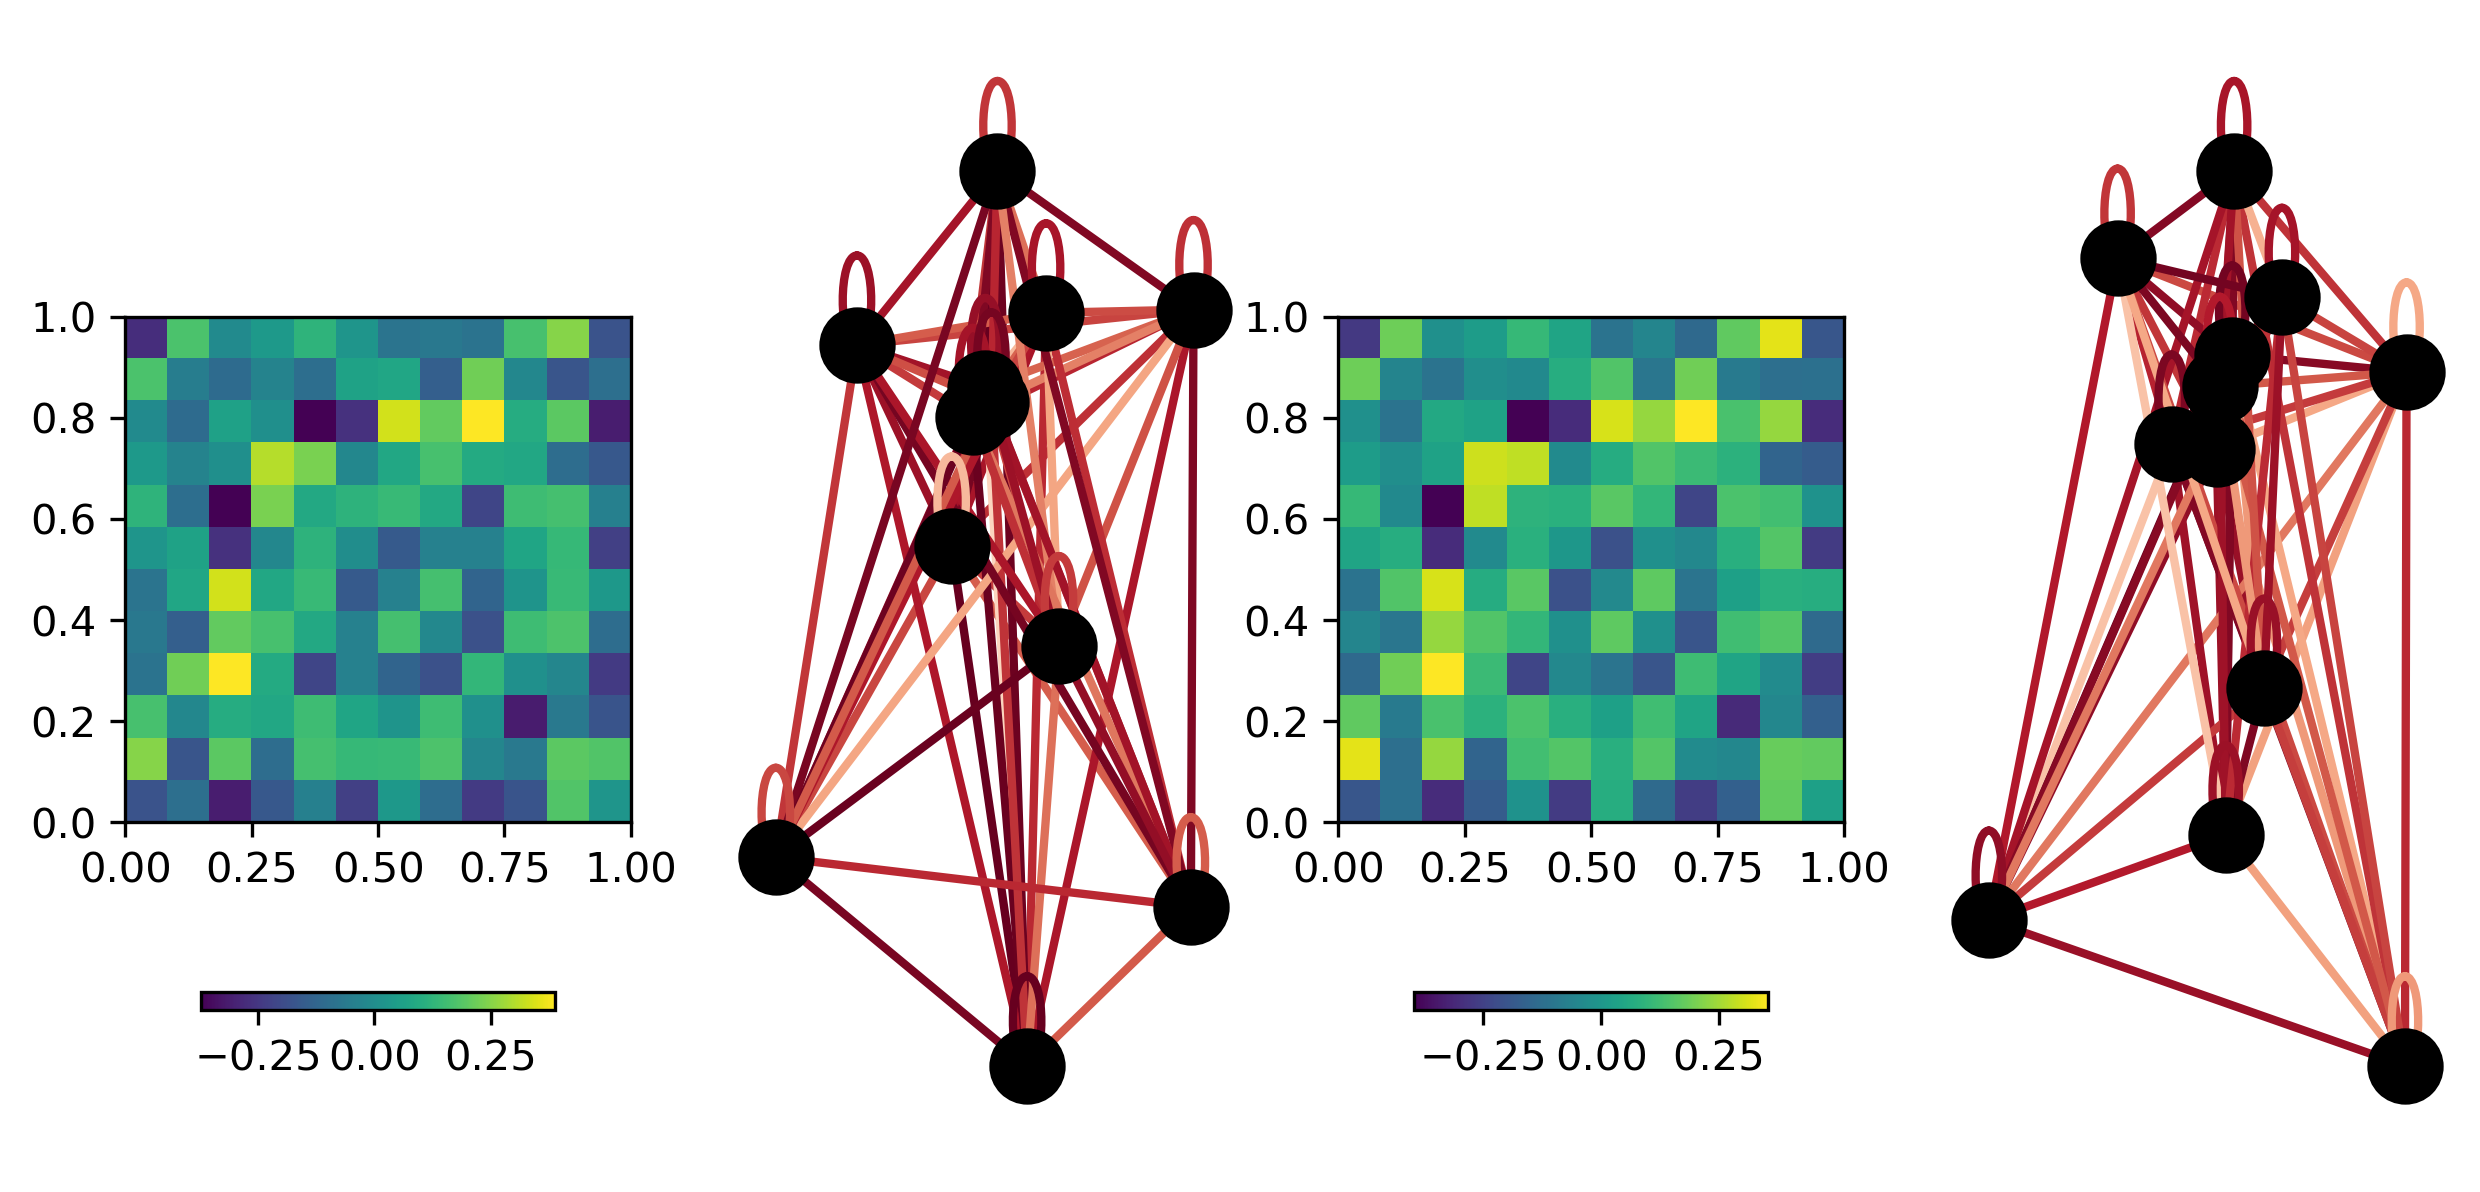

In [7]:
A, B, P, p = gauss_wigner(12,0.2)
plot([A,nx.from_numpy_matrix(A),P@B@la.inv(P),nx.from_numpy_matrix(B)])

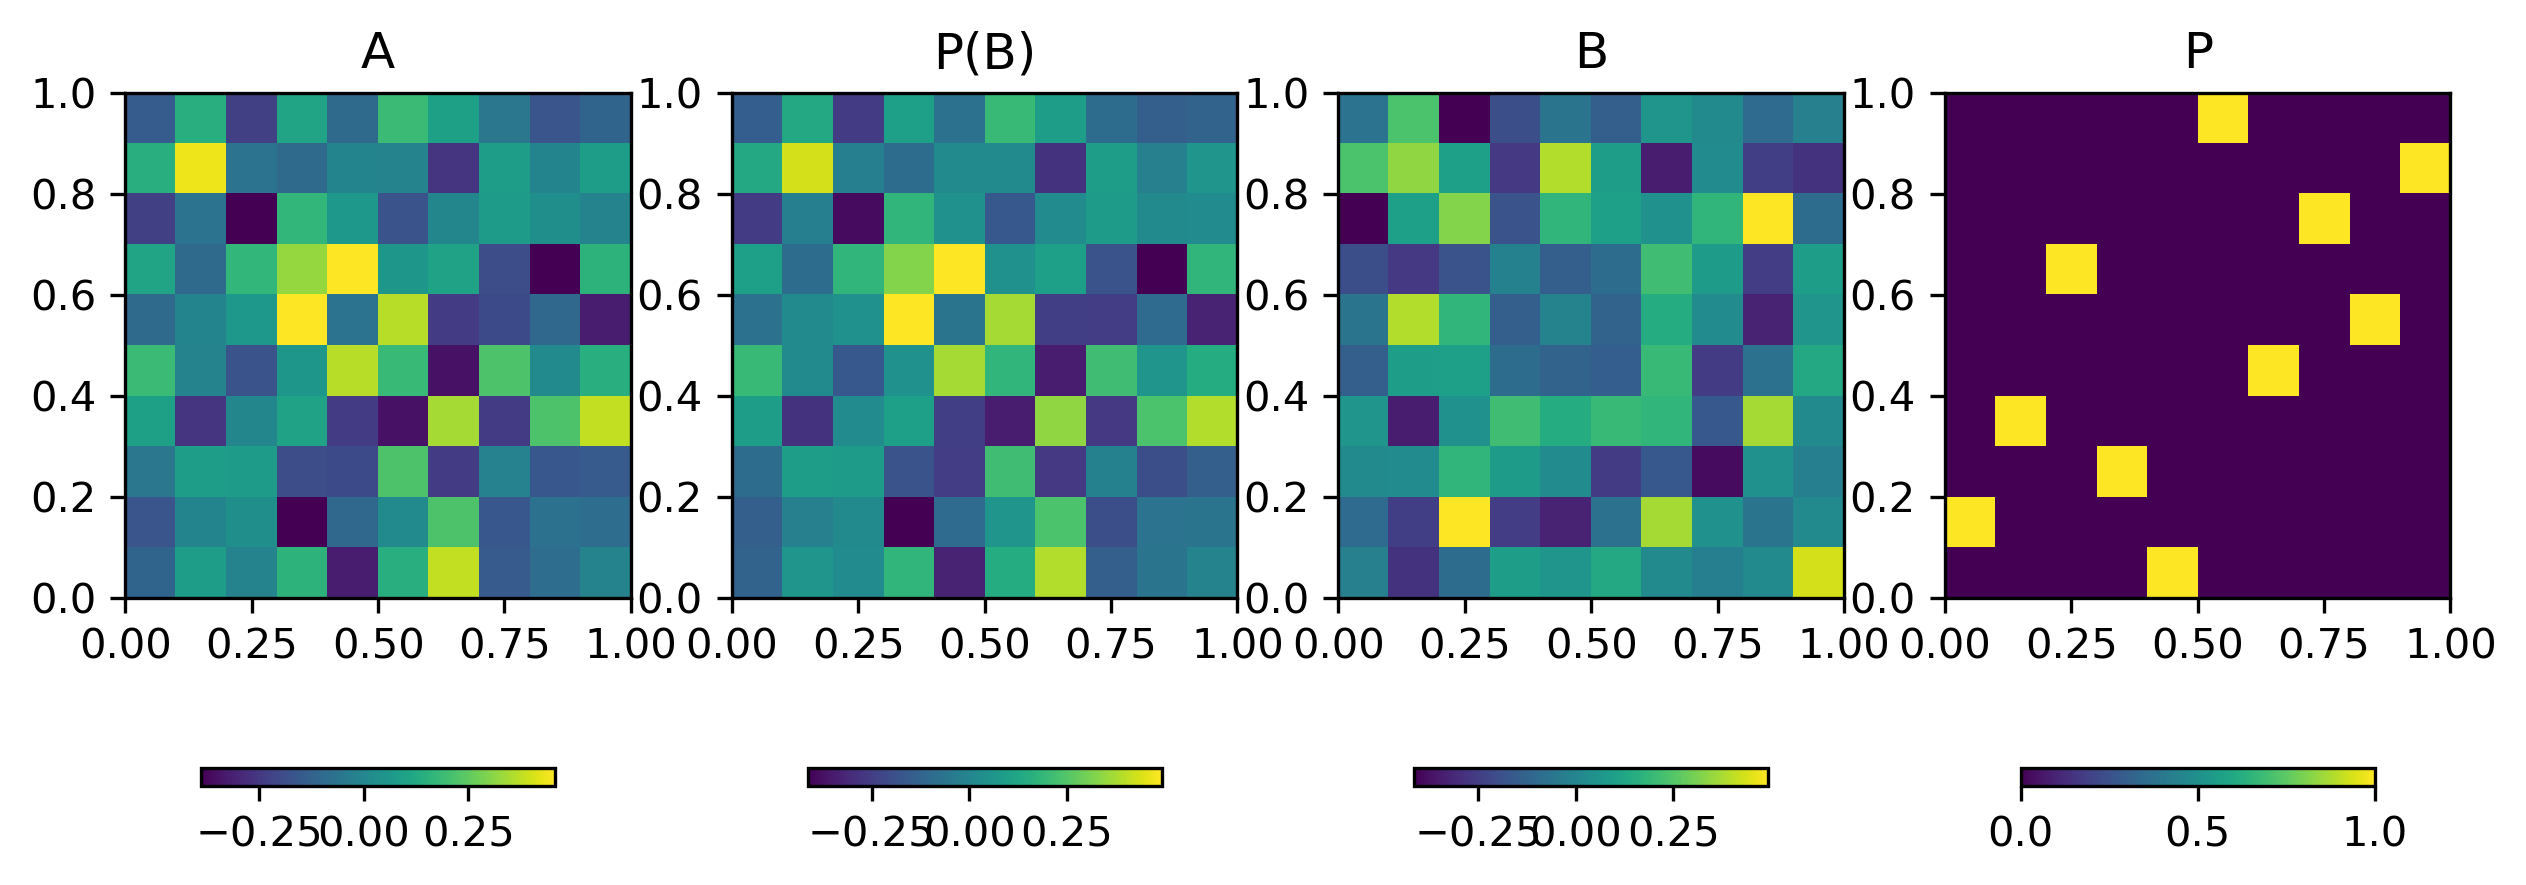

In [8]:
n = 10
sigma = 0.1
A, B, P, p  = gauss_wigner(n, sigma)
plot([A,P@B@la.inv(P),B,P],['A','P(B)','B','P'])


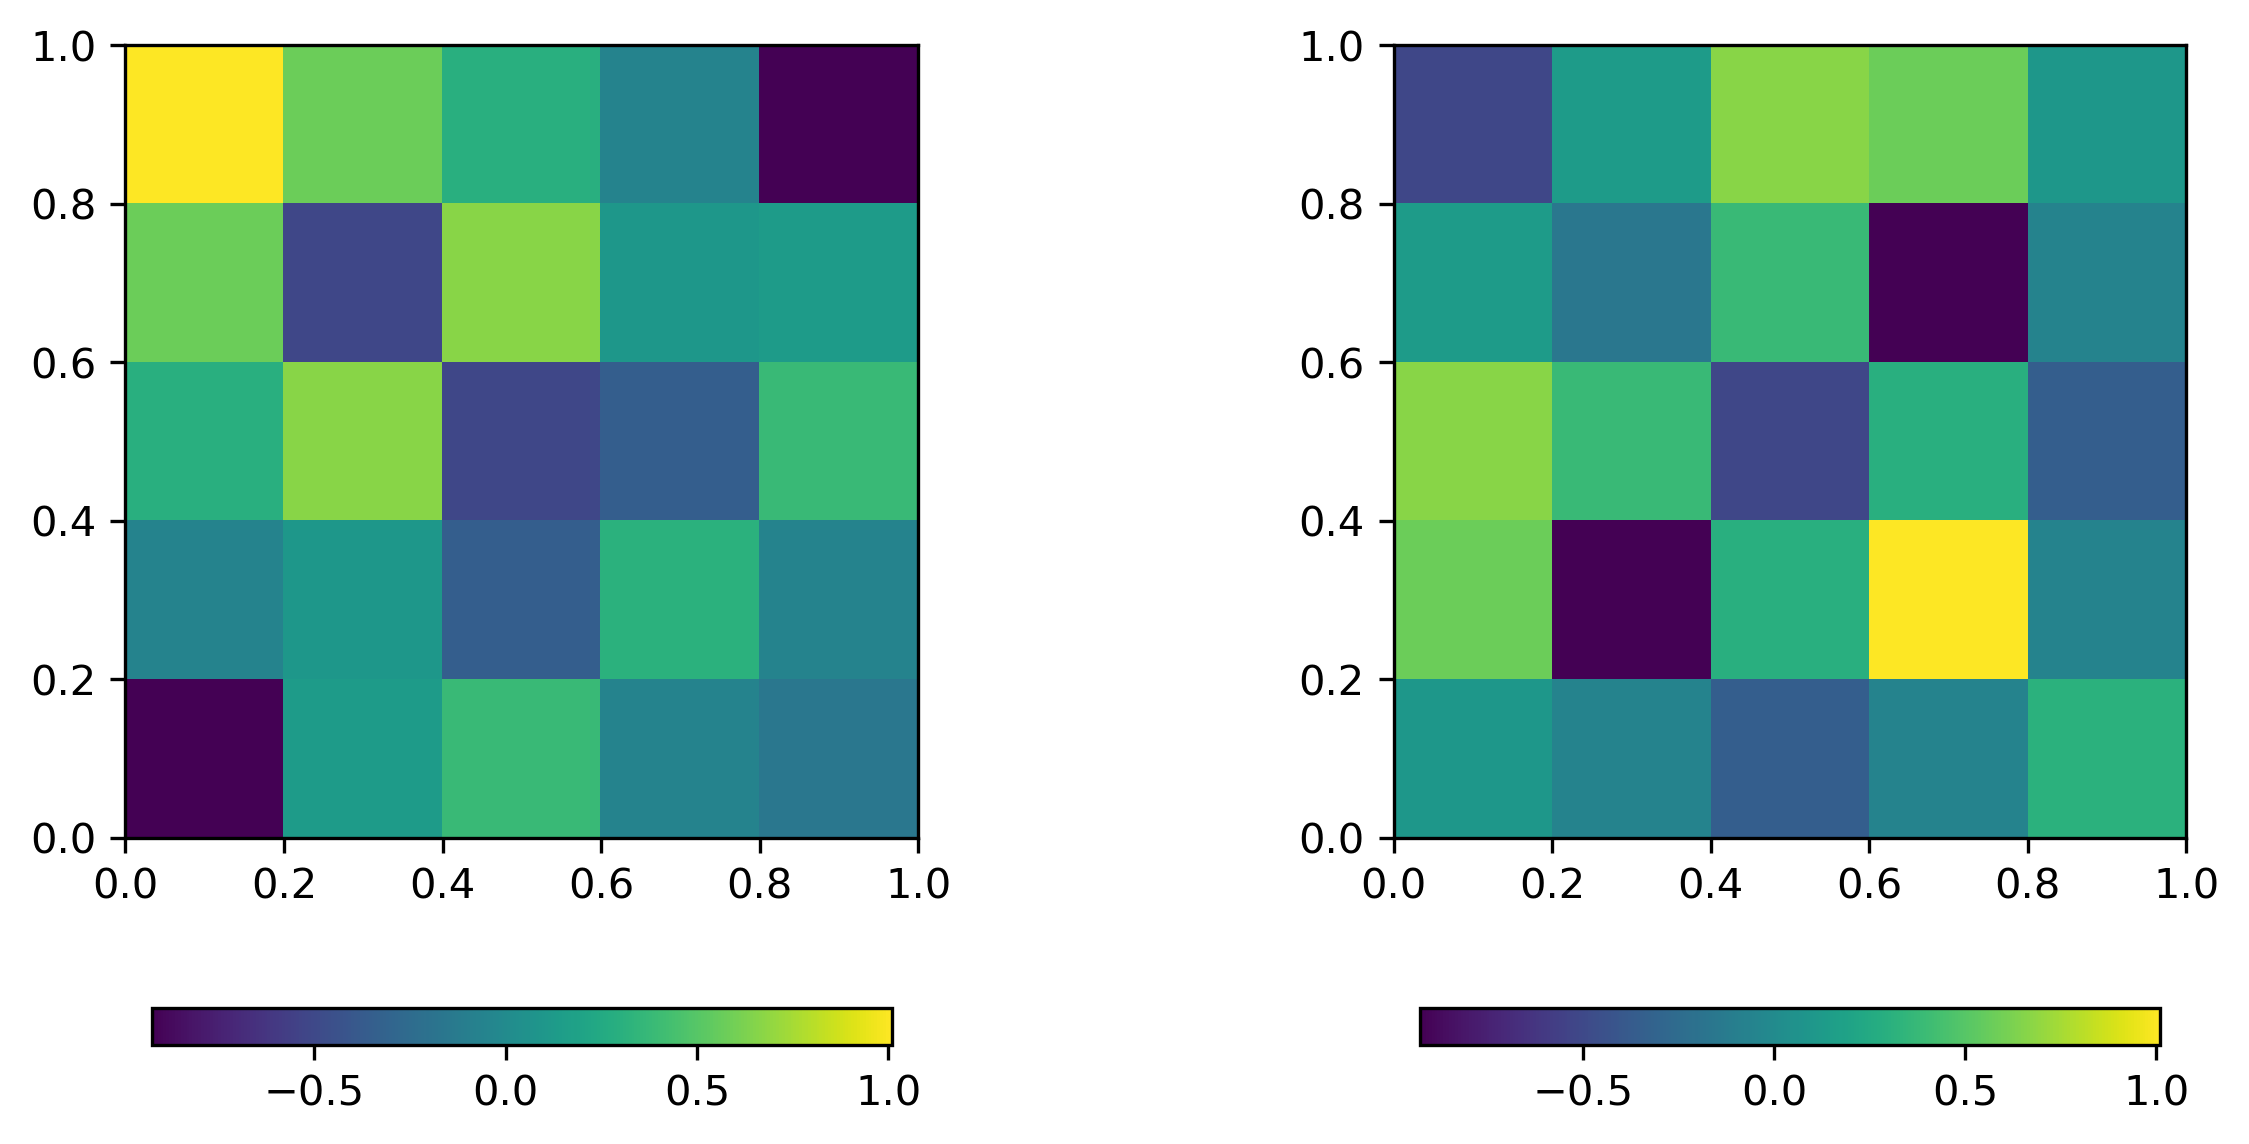

In [10]:
A, B, P, p = gauss_wigner(5,0.00001)
# plot(nx.from_numpy_matrix(A))
# plot(nx.from_numpy_matrix(B))
plot([A,B])

## Naive Alg impementation

In [51]:
def similarity(A,B,n,eta):
    def kernel(x,y):
        return 1/((x-y)**2+eta**2)
    lambdas, us = la.eig(A)
    mus, vs = la.eig(B)
    J = np.ones((n,n))
    sim = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            sim += kernel(lambdas[i], mus[j]) * (np.outer(us[:,i],us[:,i])@J@np.outer(vs[:,j],vs[:,j]))
    return sim

def alg(A,B,n,eta):
    sim = similarity(A,B,n,eta)
    p = np.argmax(sim,axis=1)
    return sim, p
    

## Self similarity matrix example

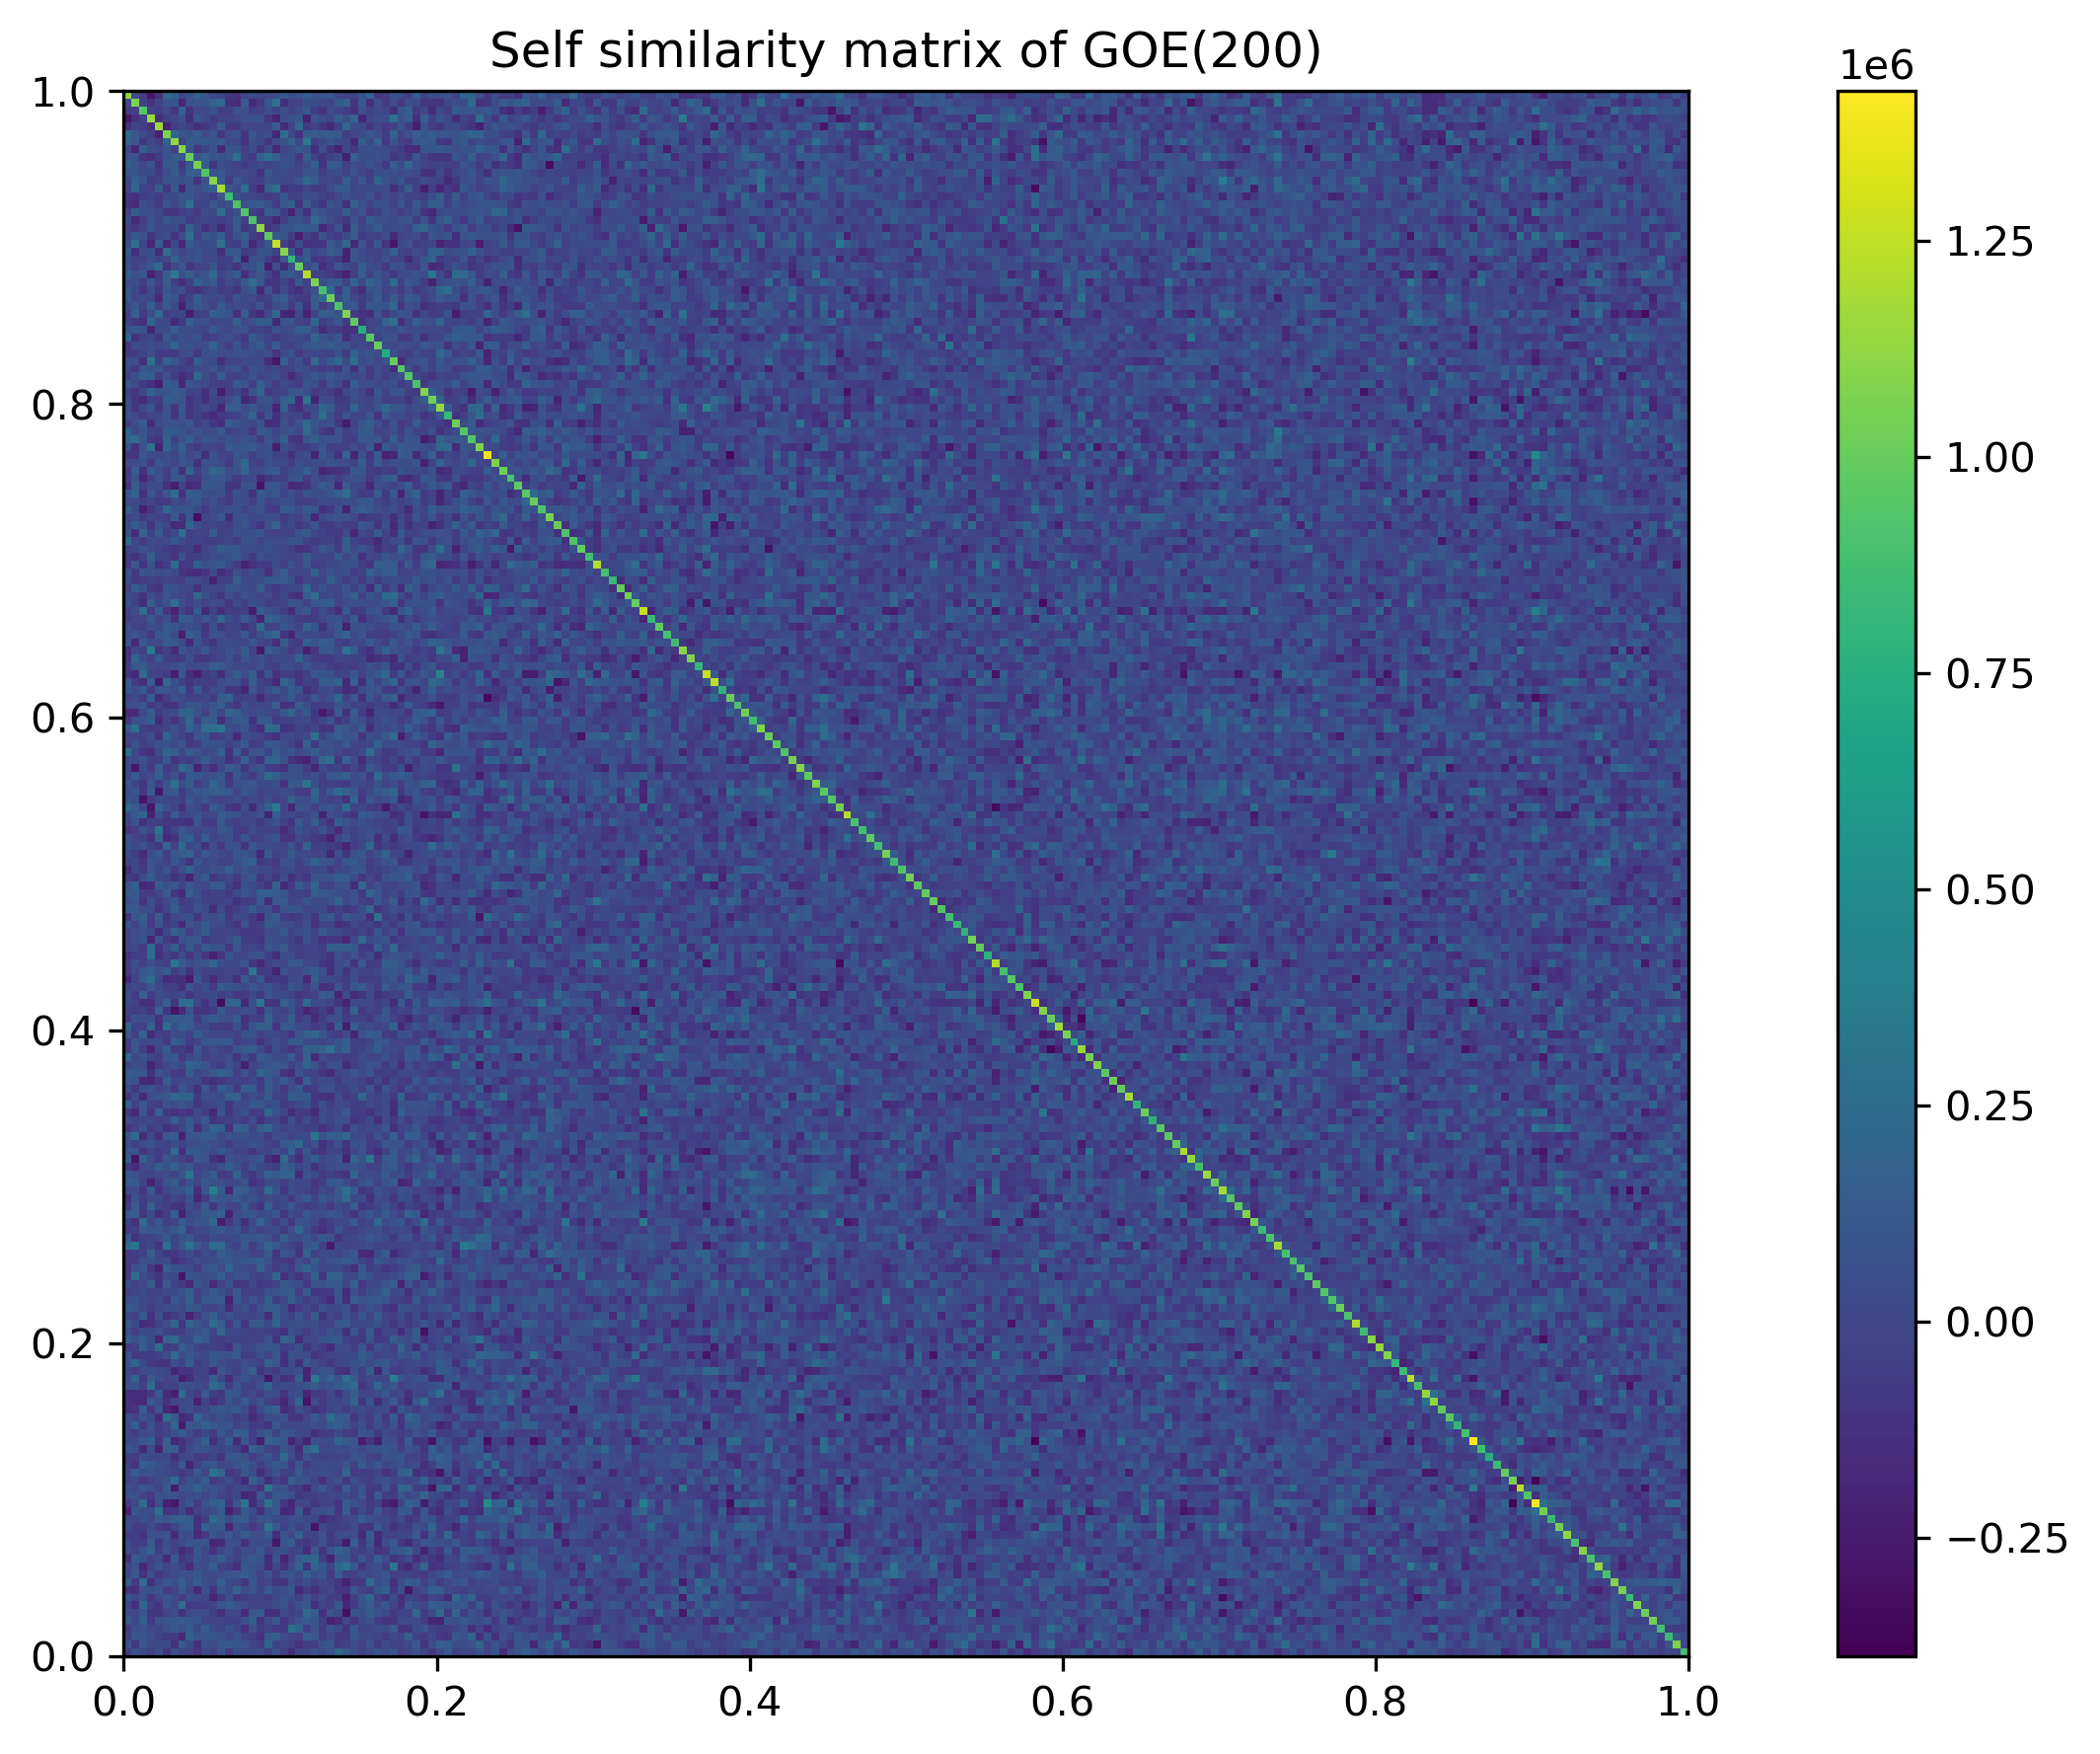

In [26]:
n = 200
A, B, P, p = gauss_wigner(n,0.01)
S = similarity(A,A,n,0.001)
plot(S,"Self similarity matrix of GOE({})".format(n))

In [50]:
np.argmax(X,axis=1)

array([101,  48,  30, 119, 130, 112,  13,  42,  77,  11,  59,  94, 150,
        44, 156, 133, 146,  35,  22,  97,  82, 128,  67,   9,  14, 154,
       151,   5, 144, 114, 116,  19,  37,  78,  89, 143,  39, 147,  52,
        88,  15,  61,  86,  12,  16, 105,  95, 158,  71,  65,  40,  51,
        73,  69,  54,  64, 125, 113,  57,  28,  43, 136,  47,  72,  56,
       135, 155,  38,  87,  99,  32, 115,  46, 131,  68,  93,  55, 109,
       148, 142, 127, 100,   2,  83, 122,  90, 157,  84, 120, 134,   3,
       110,  17, 137,   7, 106,  70,  63,  98,   0, 102, 123,  23, 111,
       145,  21, 129,  60, 149,  49, 159, 117, 121,  24, 140, 118,  96,
        58, 141,  75, 139, 124,  85,  26,  91,  41,  29,  66, 103, 107,
        45, 104,  31,  20,   1,  18,  10,  80,   8,  81, 152,   6,  50,
       153, 132, 108,  25,  79, 126,  92,  27,  74,  62,  34, 138,  76,
        33,   4,  53,  36])

In [69]:
p

array([50, 26, 16, 15, 19, 42, 40, 30, 14, 24, 46,  6,  7, 47, 20, 51, 58,
       53, 13, 11, 55, 17, 33, 43, 23, 45, 21, 44, 37,  9, 32, 10,  4, 56,
       22, 28, 39,  0, 12, 27, 18, 52, 25, 59,  8, 29,  1, 48, 31, 35, 57,
        2,  5, 54, 38, 49, 36, 41, 34,  3])

61


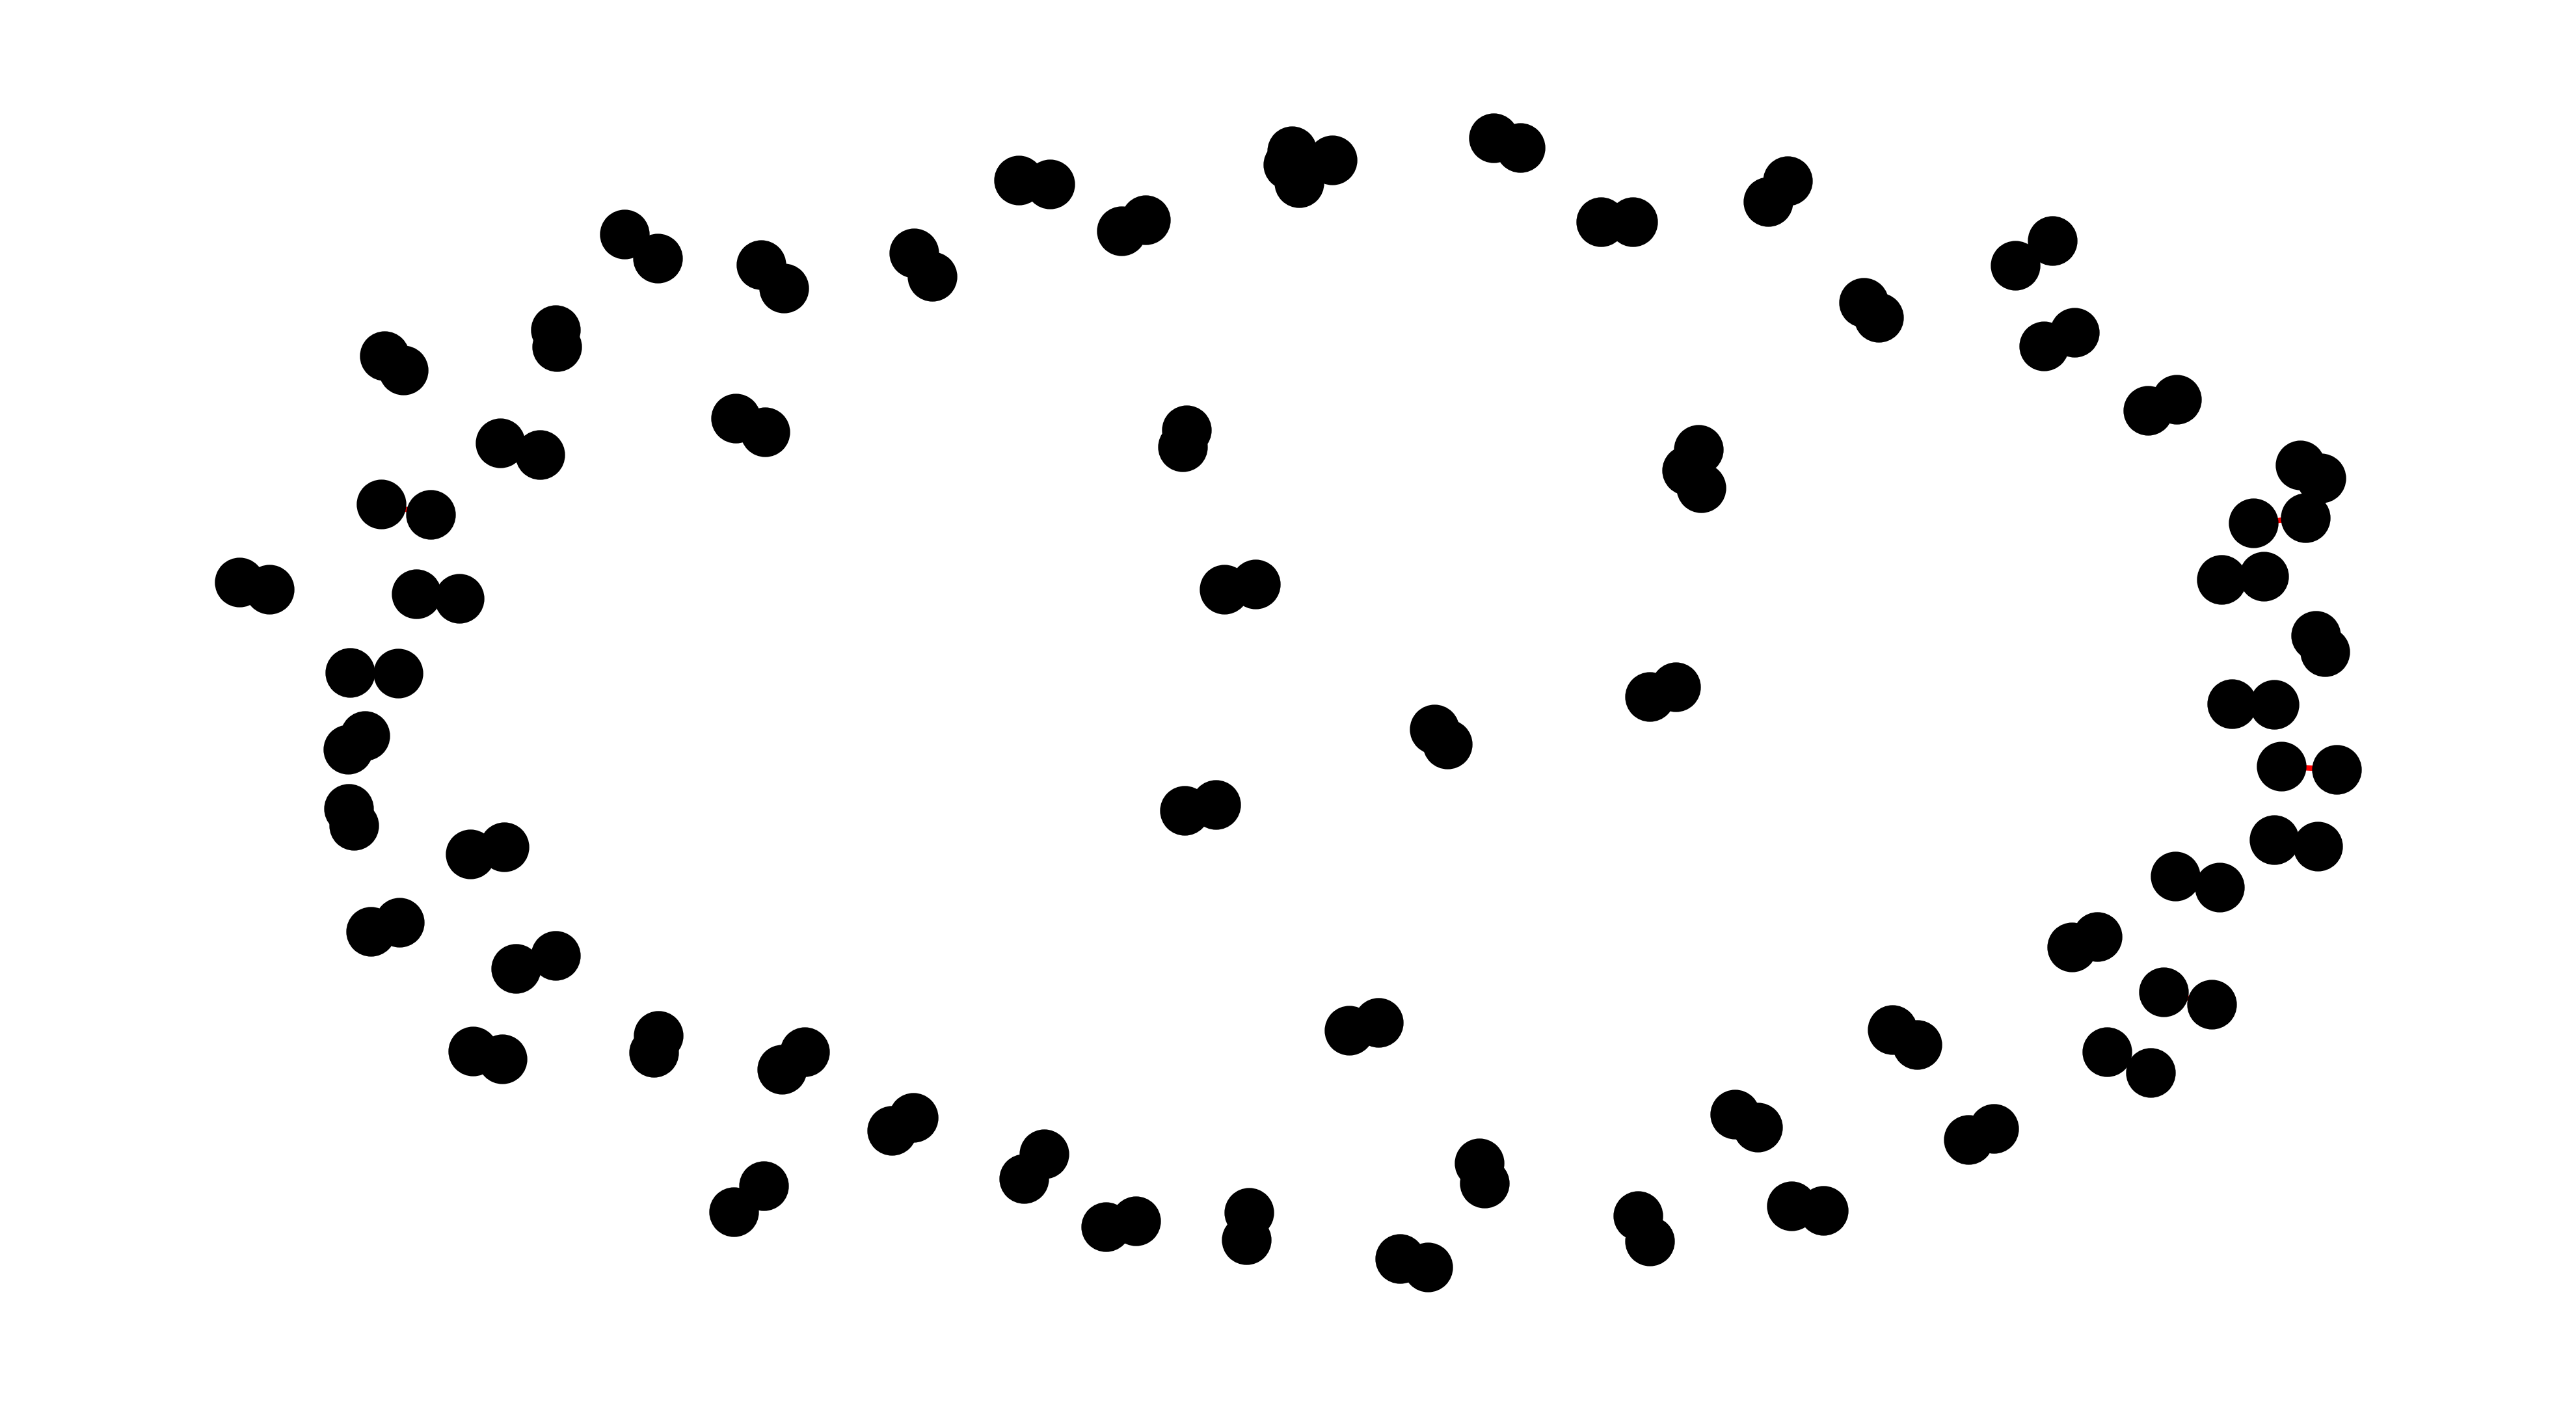

In [75]:
def vertexMatching(p1,p2):
    G = nx.Graph()
    for i in range(len(p1)+1):
        G.add_node(i)
        G.add_node(i+len(p1))
    for i in range(len(p1)+1):
        G.add_edge(i,i+len(p1))
    nx.draw(G,edge_color='r',node_color = 'k',width = 2)
    print(G.number_of_edges())
vertexMatching(p,perm)

[46 57 21 51 42 14 25 56 35 27 23 37 36 41 52 38 15 44  0 11  1 20 31  7
 40 28 26 50 22 19  8 45  5 47 29 33 43  9 48 53 59 34 49 13 24 18 17 30
  3 39 54  2 12 55  4  6 58 32 10 16]
[46 57 21 51 42 14 25 56 35 27 23 37 36 41 52 38 15 44  0 11  1 20 31  7
 40 28 26 50 22 19  8 45  5 47 29 33 43  9 48 53 59 34 49 13 24 18 17 30
  3 39 54  2 12 55  4  6 58 32 10 16]


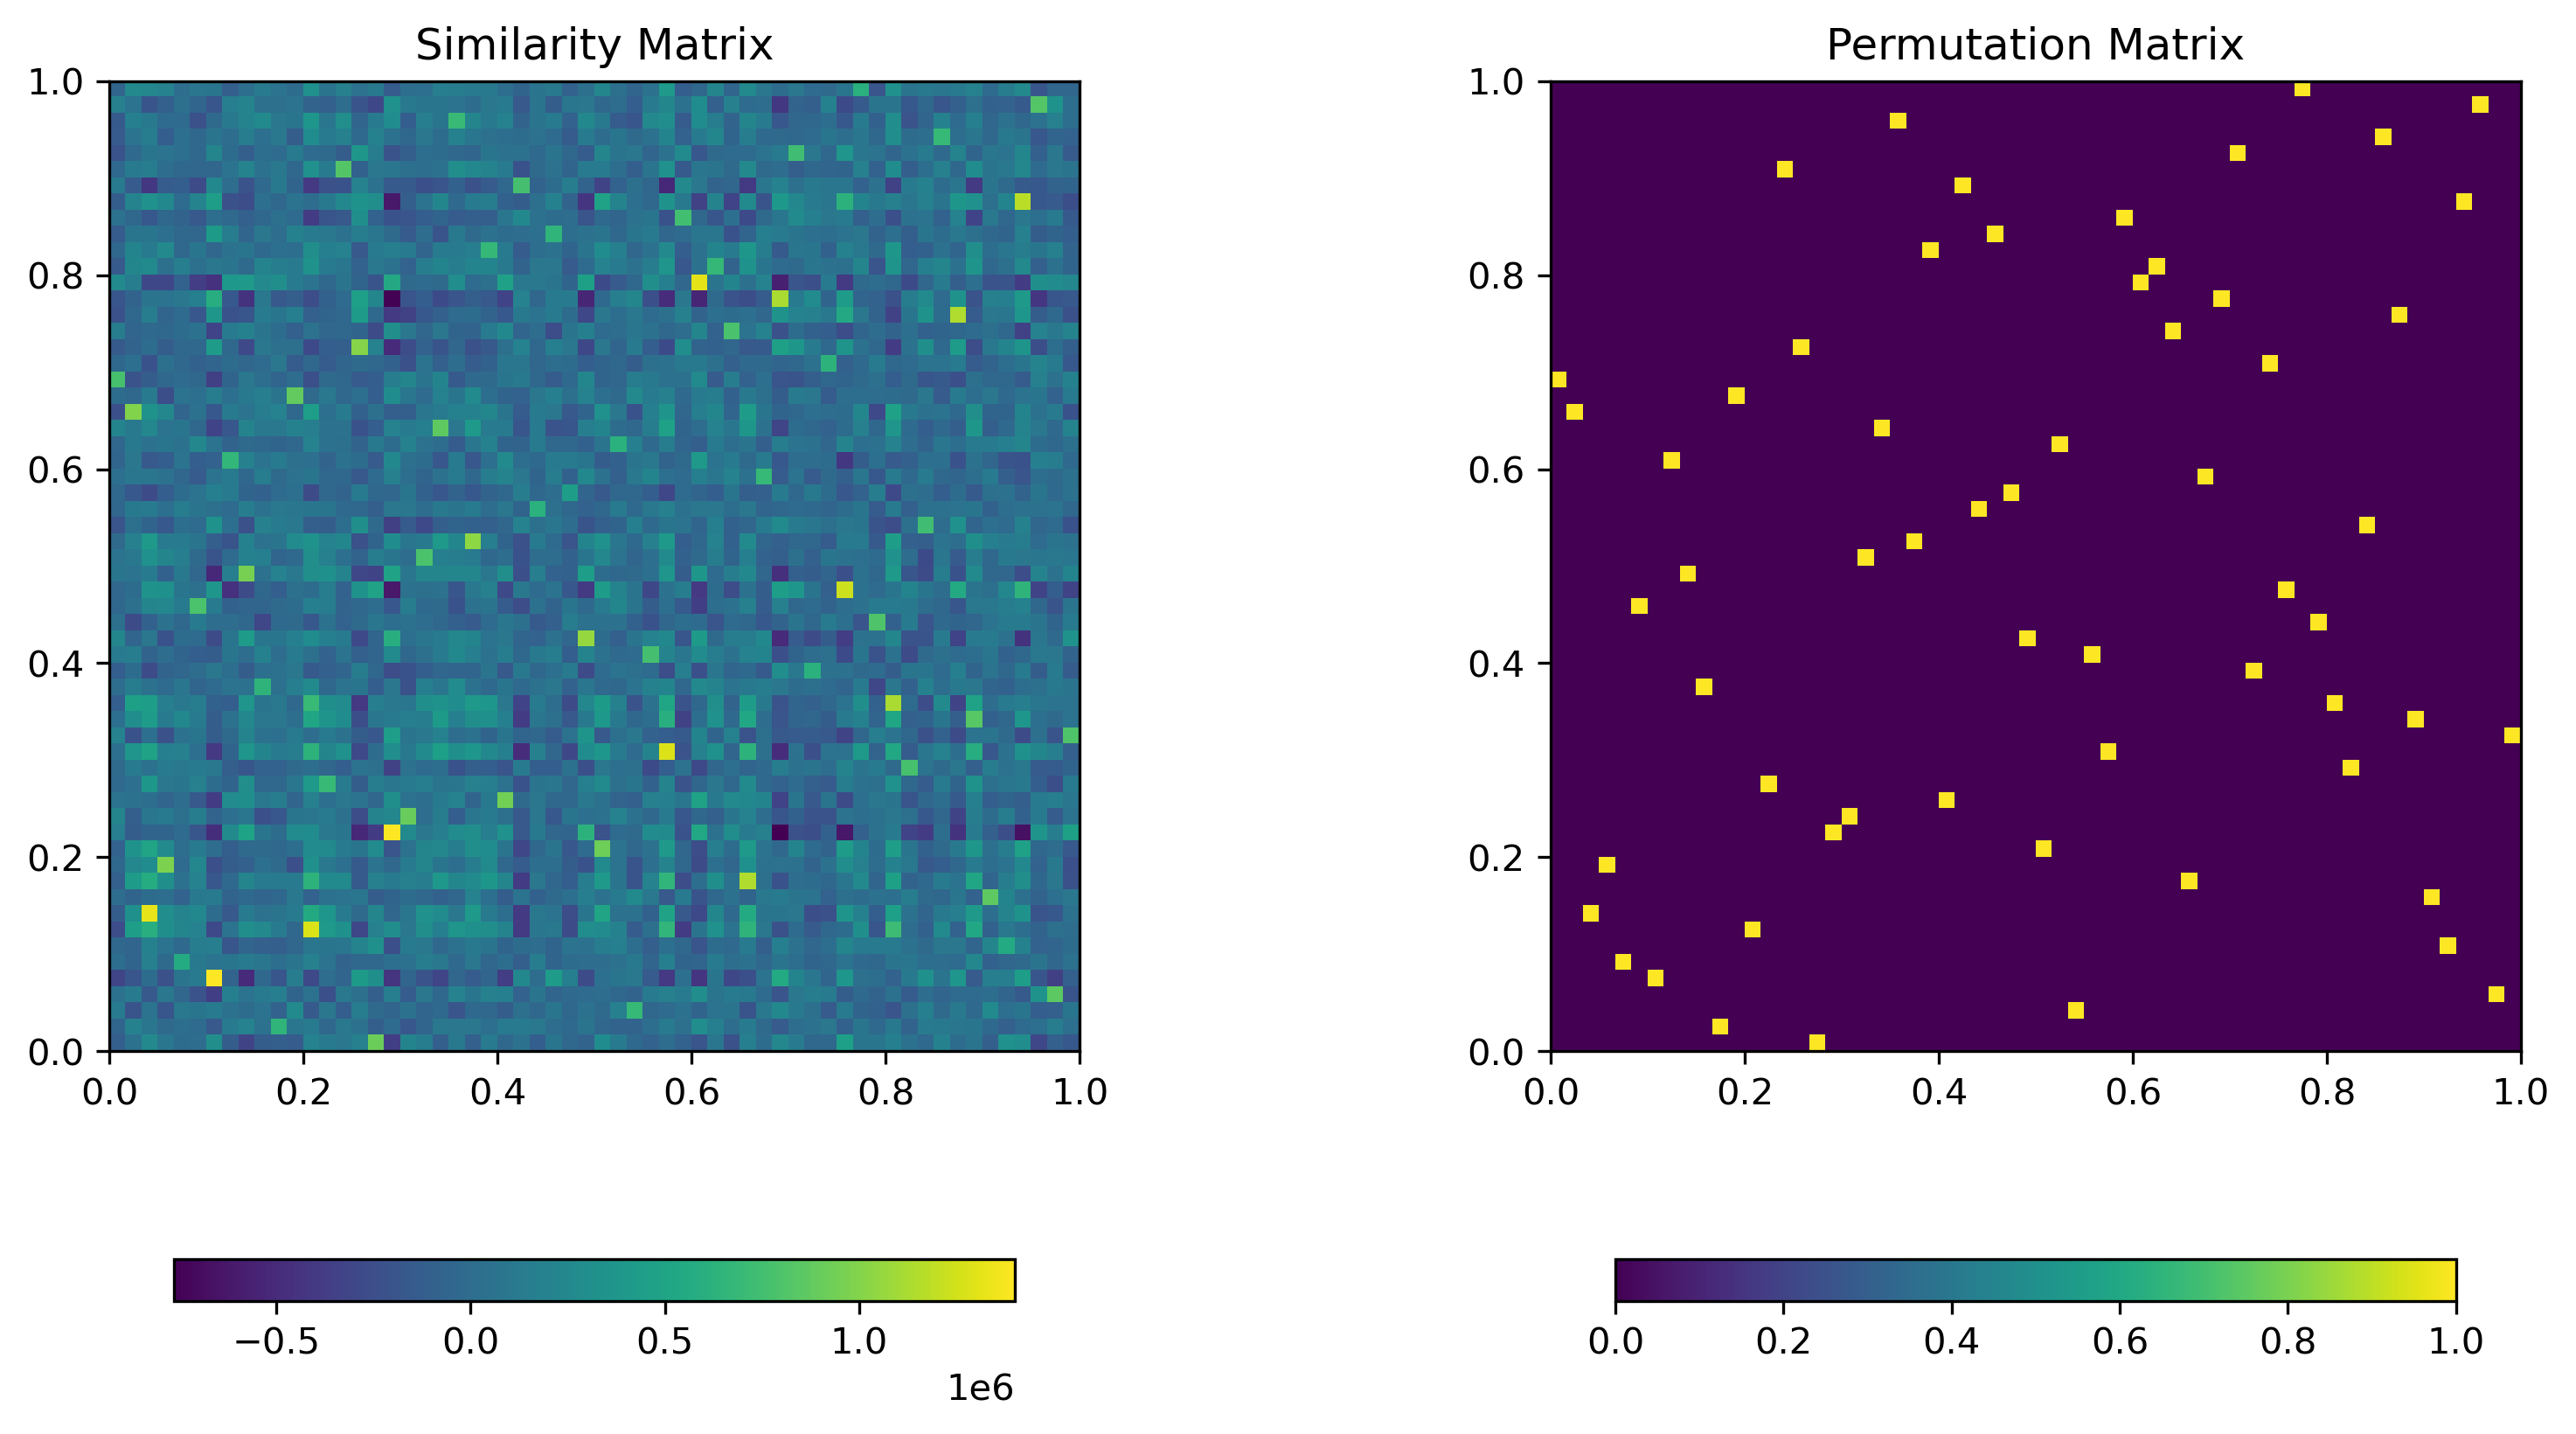

In [76]:
n = 60
sigma = 0.01
eta = 0.001 #np.log(n)
A, B, P, p = gauss_wigner(n, sigma)
X, perm = alg(A,B,n,eta)
plot([X,P],['Similarity Matrix','Permutation Matrix'])
print(p)
print(perm)

## Report plots

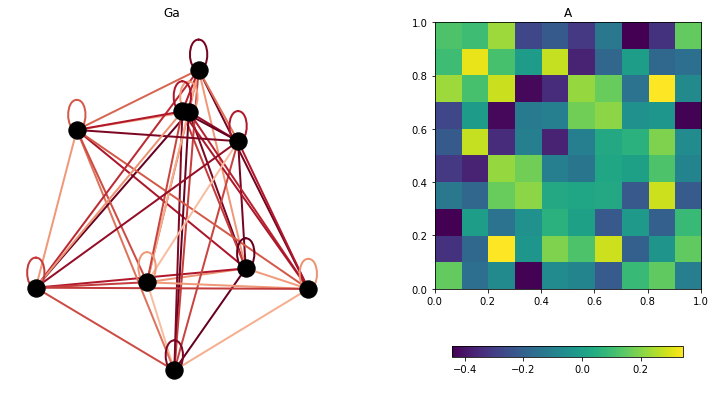

In [230]:
G = create_gaussian_graph(10)
plot([G,nx.adjacency_matrix(G).toarray()],['Ga','A'])

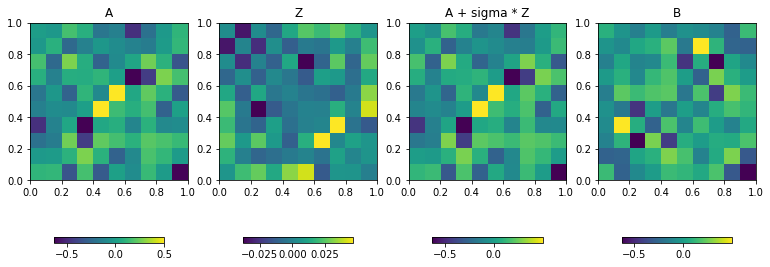

In [233]:
n = 10
sigma = 0.1
P, p = p_matrix(n)
A = nx.adjacency_matrix(create_gaussian_graph(n)).toarray()
sZ = nx.adjacency_matrix(create_gaussian_graph(n,sigma)).toarray()
ipB = A + sZ
B = la.inv(P)@ipB@P
plot([A,sZ,ipB,B],['A','Z','A + sigma * Z','B'])